# Lesson 6: Pets Revisited

We now revisit the pets imageset that we covered in Lesson 1. However, this time we make a deeper exploration of image data augmentation.

We conclude the notebook by looking at how a convolution kernel functions, and we use this knowledge to write the code to generate from scratch a heatmap that will indicate what parts of a picture most heavily influenced the algorithm's prediction of pet breed. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *

In [9]:
# Get nicer looking graphs for retina displays
%config InlineBackend.figure_format = 'retina'

In [2]:
bs = 64

In [3]:
path = untar_data(URLs.PETS)/'images'

## Data Augmentation

In [4]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

It's important that none of the transforms we apply make any of the training pictures look excessively different than their counterparts in the validation and test sets.

For example, if none of the pictures in the validation or test sets are exceptionally bright, we shouldn't create any augmented training images that are exceptionally bright.

Indeed, above we set the `max_lighting` parameter to only `0.4`.

In [5]:
src = ImageItemList.from_folder(path).random_split_by_pct(0.2, seed=2)

In [6]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
            .transform(tfms, size=size, padding_mode=padding_mode)
            .databunch(bs=bs).normalize(imagenet_stats))

In [20]:
data = get_data(224, bs, 'zeros')

The fastai library supports using a black background behind image augmentations that have been rotated, etc. This tends to result in improved performance. Most other libraries just put in a white background, or zoom in far enough so that the augmented image's pixels cover the full area of the square.

In [10]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

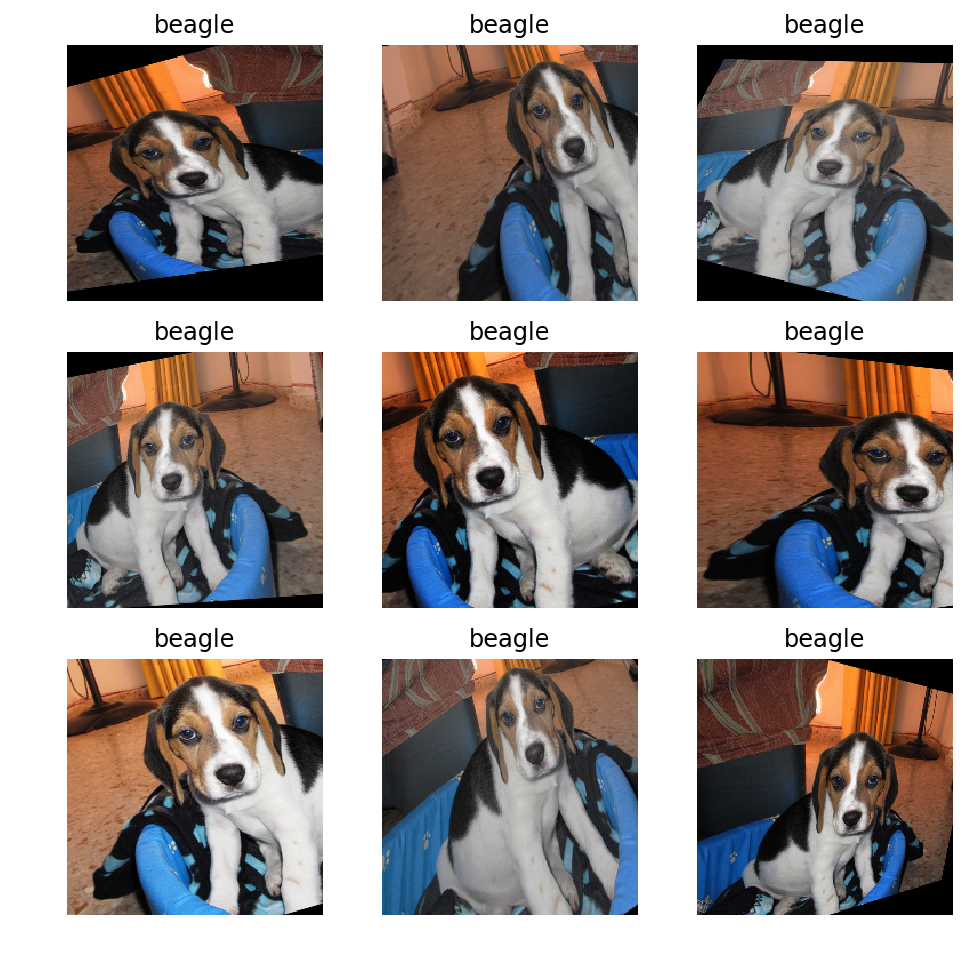

In [21]:
plot_multi(_plot, 3, 3, figsize=(8,8))

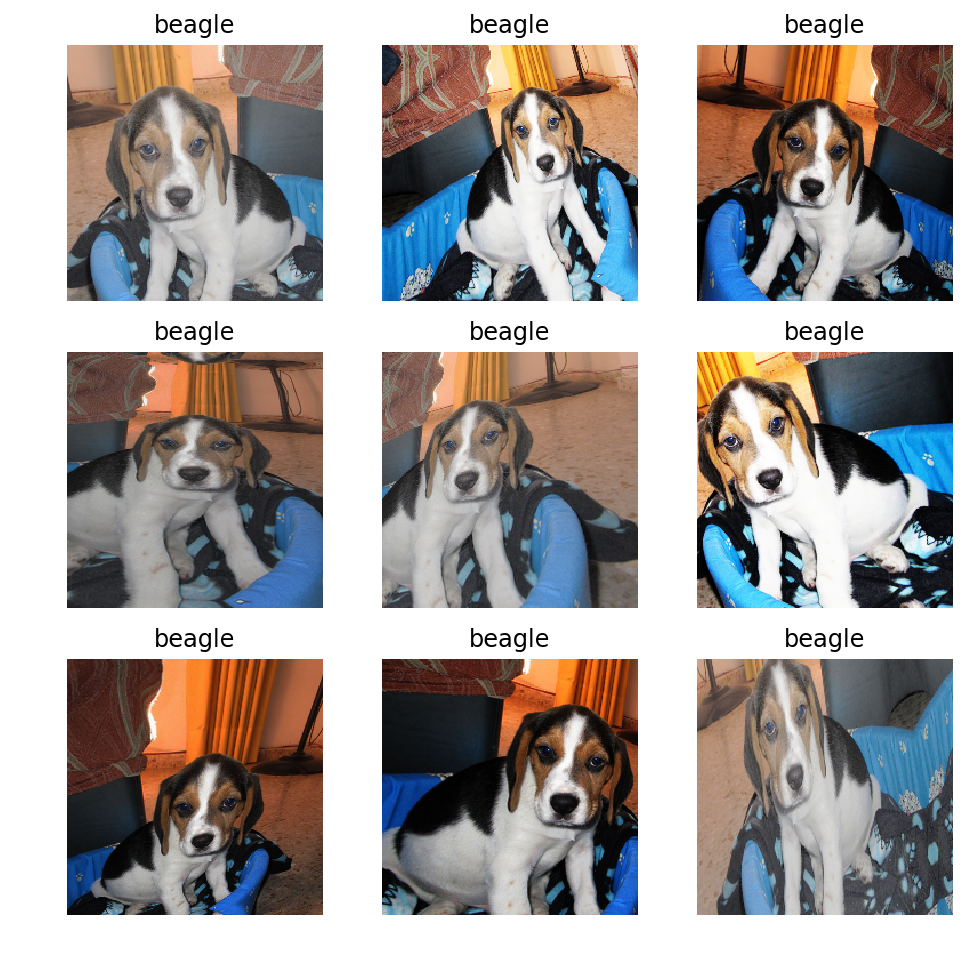

In [23]:
data = get_data(224, bs)
plot_multi(_plot, 3, 3, figsize=(8,8))

Not passing in the `zeros` parameter causes all augmentations to be zoomed in enough, if necessary, so that the entire square is filled with image pixels.

## Training a Model

In [26]:
gc.collect()

0

In [27]:
data = get_data(224, bs, 'zeros')

In [28]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True)

In [29]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

In [30]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-3), pct_start=0.8)

Resize to 352 x 352

In [31]:
data = get_data(352, bs, 'zeros')

In [32]:
learn.data = data

In [33]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

In [34]:
learn.save('352')

## Understanding a Convolution Kernel

In [35]:
data = get_data(352, 16)

In [36]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category Persian

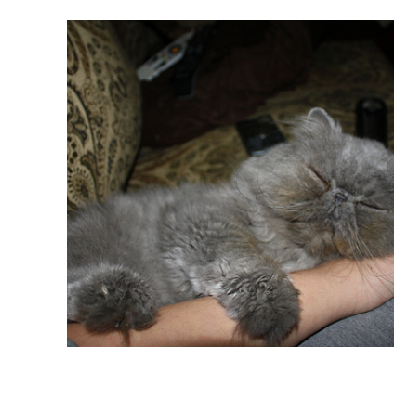

In [38]:
idx = 0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

Let's create a simple 3 by 3 kernel that would detect edges in an image:

In [39]:
k = tensor([
    [0.  , -5/3, 1],
    [-5/3, -5/3, 1],
    [1.  , 1   , 1]
]).expand(1,3,3,3)/6

In [40]:
from fastai.callbacks.hooks import *

In [41]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [42]:
k.shape

torch.Size([1, 3, 3, 3])

Convolutional kernels for images are 3-d tensors of channel x height x width. The first dimension in the above tensor holds all the 3-d kernels (though in our example we only have one kernel, there are usually several kernels at each layer in a convolutional network).

In [43]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

We will pass our kernel over one image that has 3 channels and is 352 by 352 in size.

In [44]:
t[None].shape

torch.Size([1, 3, 352, 352])

Putting `[None]` after a tensor is a quick trick to add an extra dimension. In our case, it's to put our image into the tensor shape that PyTorch expects, where the first dimension holds all the pictures in a mini-batch. In our case, we only have one image, so our mini-batch is a size of 1.

In [45]:
edge = F.conv2d(t[None], k)

The result of running the line above is the output of passing our kernel over our image.

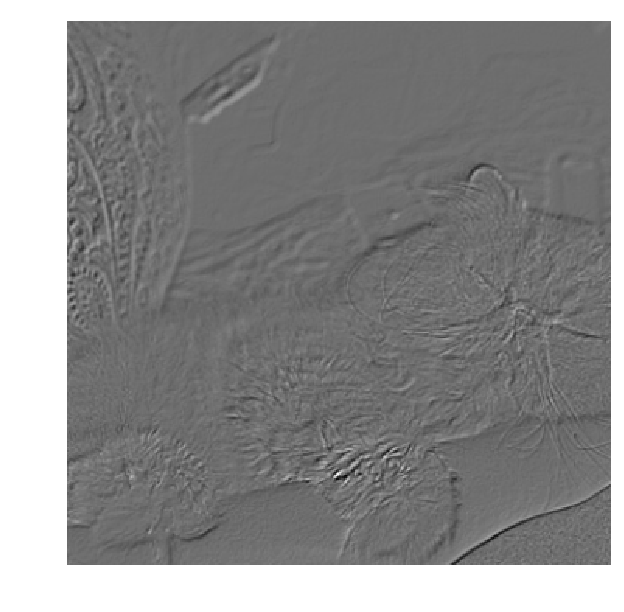

In [47]:
show_image(edge[0], figsize=(5,5));

As we can see, our kernel did a good job of detecting mamy of the edges in our cat picture.

In [48]:
learn.summary()

Input Size override by Learner.data.train_dl
Input Size passed in: 16 

Layer (type)               Output Shape         Param #   
Conv2d                    [16, 64, 176, 176]   9408                
________________________________________________________________________________
BatchNorm2d               [16, 64, 176, 176]   128                 
________________________________________________________________________________
ReLU                      [16, 64, 176, 176]   0                   
________________________________________________________________________________
MaxPool2d                 [16, 64, 88, 88]     0                   
________________________________________________________________________________
Conv2d                    [16, 64, 88, 88]     36864               
________________________________________________________________________________
BatchNorm2d               [16, 64, 88, 88]     128                 
________________________________________________________

## Creating a Heatmap

To make a heatmap, we average each pixel in the 11x11 face by across all 512 channels, this tells us, for each part of the cat's image, how many of our network's filters activated (saw something interesting) that influenced its prediction of the cat's breed.

In [49]:
m = learn.model.eval();

In [50]:
xb, _ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

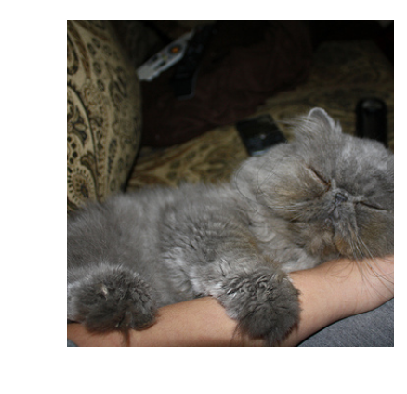

In [53]:
show_image(xb_im);

A "hook" is a PyTorch feature that lets you "hook" into the PyTorch machinery itself and run any arbitrary Python code that you may want to run.

For making the heatmap, we "hook into" the forward pass of our conv network, and tell PyTorch to store the activations of the final conv layer right after it calculates them.

That's how we get the 512x11x11 tensor that we will average across the channel dimension in order to get our 11x11 heatmap.

In [51]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a:
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0, int(cat)].backward()
    return hook_a, hook_g

In [54]:
hook_a, hook_g = hooked_backward()

Here are the activations (output) from the final layer. They have 512 channels. We can think of these 512 channels as the 512 things that the network takes into account when determining what prediction to make for a pet's breed.

One channel could conceivably be related to eyeball shape, and perhaps another might capture color, while yet another might capture certain characteristics of an animal's fur.

In [55]:
acts = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [56]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

Taking the average across across all channels will allow us to see what 2-d locations in the image, on the average, contributed more to the network's prediction.

In [57]:
def show_heatmap(hm):
    _, ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              # The magma colormap is what gives our heatmap its "heat"
              interpolation='bilinear', cmap='magma'); 

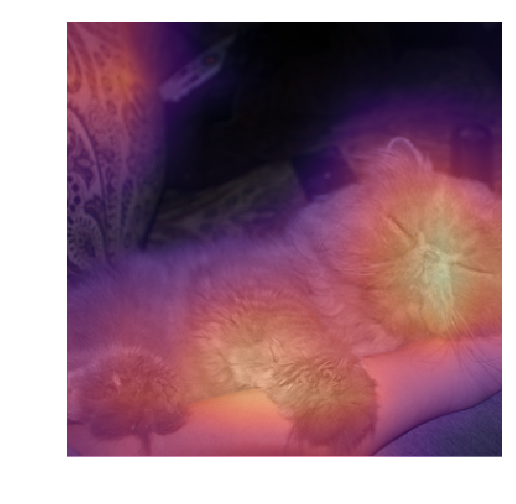

In [58]:
show_heatmap(avg_acts)

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

Grad-CAM, or Gradient-weighted Class Activation Mapping, looks at the *gradients* flowing into the final convolutional layer to produce a map that highlights which regions in the 2-d image were most important in predicting its breed.

In [62]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape, grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [63]:
mult = (acts*grad_chan[...,None,None]).mean(0)

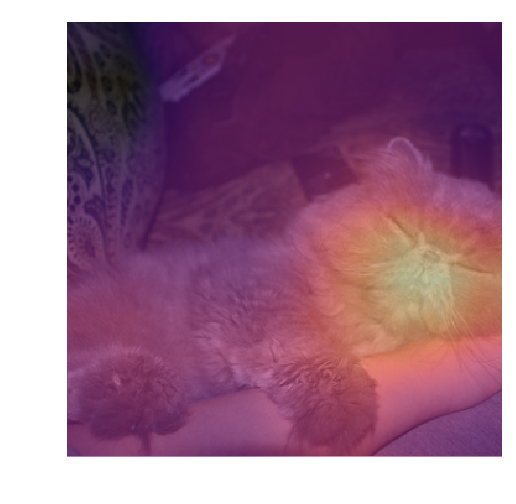

In [64]:
show_heatmap(mult)

For our image above, we see that the gradients behind the cat's face were most important. Unlike the activation-based heatmap that we produced above, only the face really mattered to the gradients, and not the cat's stomach.

We'll do one more image -- but this time, it's an image that contains two different pet breeds.

In [91]:
fn = path/'other/bulldog_maine.jpg'

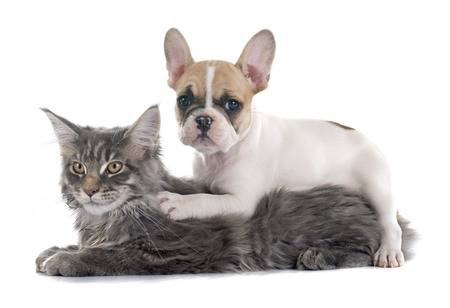

In [93]:
x = open_image(fn); x

In [94]:
xb, _ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [95]:
hook_a, hook_g = hooked_backward()

In [96]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

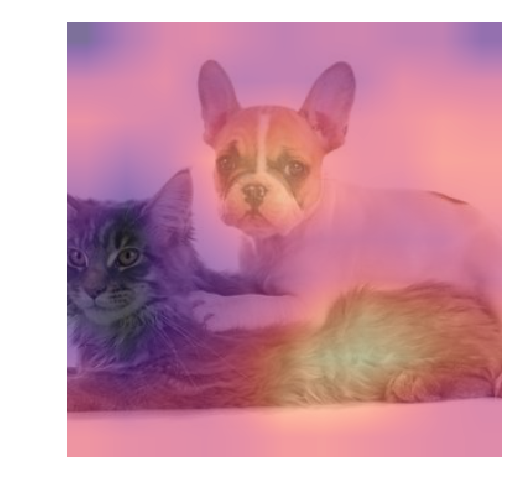

In [97]:
show_heatmap(mult)

Without passing a specific category to `hooked_backward()`, we can see that the model pays most attention to the dog's face, and the rear portion of the cat, when making its prediction.

We can pass a specific category to `hooked_backward()` in order to see which parts of the image look most like that category.

In [104]:
data.classes

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

`american_bulldog` is in 12th index in the category list, and it happens to be the dog's breed. Let's see what gradients our model recognizes as being most indicative of this breed of dog.

In [105]:
hook_a, hook_g = hooked_backward(12)

In [106]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

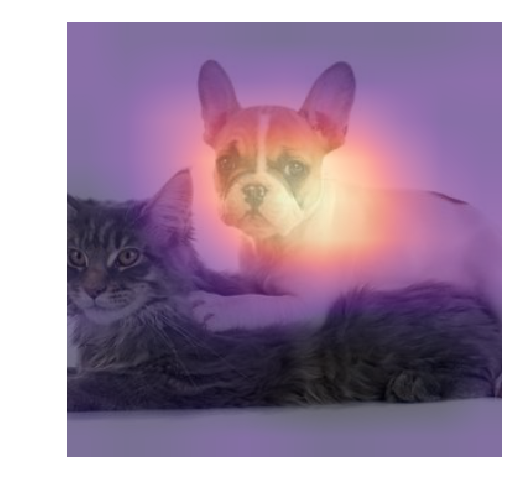

In [107]:
show_heatmap(mult)

The cat's breed happens to be a Maine Coone, which is at the 6th index in the category list. We can see which part of the image the model thinks looks most like a Maine Coone.

In [108]:
hook_a, hook_g = hooked_backward(6)

In [109]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

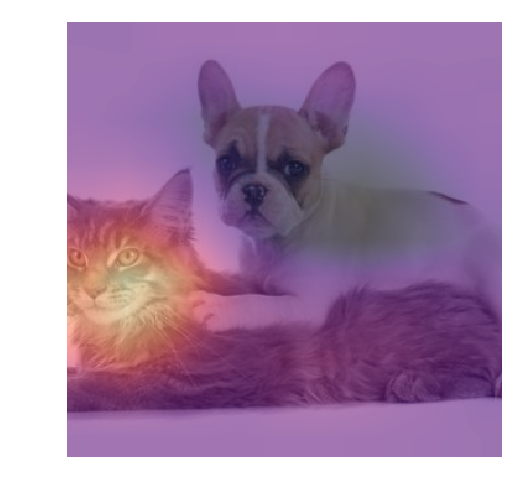

In [110]:
show_heatmap(mult)